# Natural Language Processing

For this little project we want to get familiar with the NLTK library (see documentation [here](https://www.nltk.org/index.html)).

We will create a simple spam filter based on the [SMS Spam Collection dataset](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection) from the University of California, Irvine.

Please note that nltk also has a lot of inbuilt resources accessible with the `nltk.download_shell()`command.

## First look at the dataset

In [1]:
messages = [line.rstrip() for line in open('smsspamcollection/SMSSpamCollection')]
len(messages)

5574

In [2]:
for i, m in enumerate(messages[:10]):
    print("[{}]".format(i), m)
    print("\n")

[0] ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


[1] ham	Ok lar... Joking wif u oni...


[2] spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


[3] ham	U dun say so early hor... U c already then say...


[4] ham	Nah I don't think he goes to usf, he lives around here though


[5] spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv


[6] ham	Even my brother is not like to speak with me. They treat me like aids patent.


[7] ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune


[8] spam	WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 090617

As we can see, each element contains two fields separated by a tab where the first field is the label and the second the message. This is even clearer with:

In [3]:
messages[1]

'ham\tOk lar... Joking wif u oni...'

### Imports

In [4]:
import nltk
import pandas as pd
import numpy as np

### Primary analysis

In [5]:
msg = pd.read_csv('smsspamcollection/SMSSpamCollection', sep='\t', names=['label', 'message'])
msg.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
msg.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


We can further check the description of the data by grouping the messages by label.

In [7]:
msg.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

#### It's all about features

It is at this point that we can already try to think about the features we will be using. In NLP, a large part of the work is [**feature engineering**](https://en.wikipedia.org/wiki/Feature_engineering). Obviously the better our knowledge about the domain of our data, the more features we will be able to extract from it.

For example, it might be relevant to check the lenght of the messages:

In [8]:
msg['lenght'] = msg['message'].apply(len)
msg.head()

,label,message,lenght
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


### Data Visualization

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style('darkgrid')

Distribution of the message lenght

<AxesSubplot:ylabel='Frequency'>

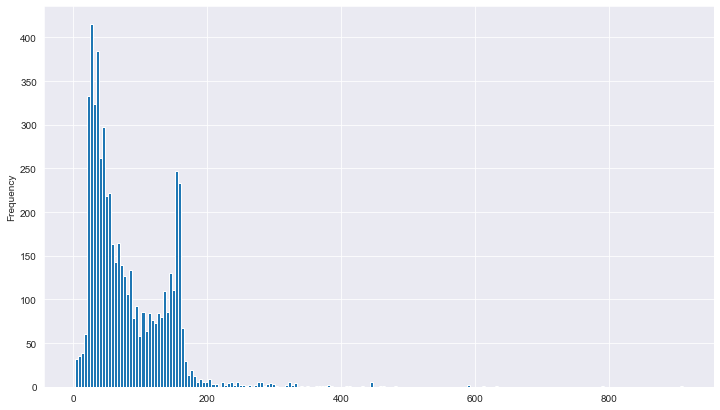

In [10]:
plt.figure(figsize=(12, 7))
msg['lenght'].plot.hist(bins=200)

We can see that there are two clear peaks of messages. One at around 50 ~ 75 characters and one at around ~160 characters. Also a minority are over 200 and the scale seems to increase untill the 1000s.

This leaves me to wonder: "What is the longest message we have in there ?"

In [11]:
msg['lenght'].describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: lenght, dtype: float64

The longest message is 910 characters long. Let's check it out.

In [13]:
msg[msg['lenght'] == 910]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

array([<AxesSubplot:title={'center':'ham'}>,
       <AxesSubplot:title={'center':'spam'}>], dtype=object)

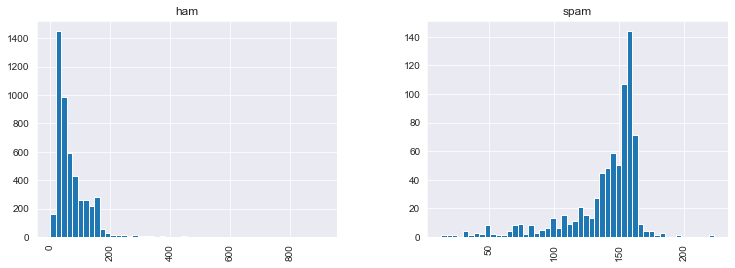

In [14]:
msg.hist(column='lenght', by='label', bins=50, figsize=(12,4))

# This is the equivalent to:
# q = sns.FacetGrid(data=msg, col='label')
# q.map(sns.histplotplot, 'lenght')

From this **very basic** analysis, it looks like *Ham* messages tend to be shorter than *Spam* messages. As such, lenght is already a good feature to distinguish *Ham* from *Spam*.

## Document preprocessing

Machine Learning algorithms require numerical data to function. That is why we need to find a way to convert our corpus of strings into a features vector.

The simplest method is by creating a **Bag of Words**.

First we want to get a list of all words in the messages for each message. This list should not contain the very frequent words like «a», «the», «if» etc. Nor should it contain punctuation.

To achieve this we will use the builtin python string library.

### Removing the punctuation

In [19]:
import string

In [20]:
sample = 'This is a sample message ! Notice: it has some punctuation.'

In [21]:
# string.puctuation is a string of characters containing only punctuation

no_punctuation = ''.join([c for c in sample if c not in string.punctuation])
no_punctuation

'This is a sample message  Notice it has some punctuation'

### Removing the stopwords

In [22]:
from nltk.corpus import stopwords

In [23]:
# stopwords.words('english') is a list of words

clean_message = [word for word in no_punctuation.split() if word.lower() not in stopwords.words('english')]
clean_message

['sample', 'message', 'Notice', 'punctuation']

#### Now let's make a nice function of this

In [24]:
def get_word_list(message):
    """Return list of words composing given message.
    The list should not contain any stopwords (like 'a', 'the', 'if').
    That is where our download from nltk comes into play.
    """
    no_punctuation = ''.join([character for character in message if character not in string.punctuation])
    clean_list = [word for word in no_punctuation.split() if word.lower() not in stopwords.words('english')]
    return clean_list

The process of removing the punctuation and the stopwords and to make a list out of the remaining words is called **tokenization**.

Now that we have our tokens, we want to create our vectors.

## Vectorization

Let's convert each message, represented as a list of tokens, into a vector that machine learning models can understand.

We'll do that in three steps using the bag of words model:

1. Count how many times does a word occur in each message (Known as term frequency)
2. Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)
3. Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

### Term Frequency

Each vector will have as many dimensions as there are unique words in the SMS corpus. To do this we will use SciKit Learn's `CountVectorizer`. This estimator will convert a collection of text documents into a matrix of token counts.

This results in something similar to a 2-dimensional matrix where 1-dimension is the entire vocabulary (1 row per word) and the other dimension are the actual documents (in this case, one column per message).

However since all the words will be present in the first dimension, we do expect a lot of zero counts for the presence of each specific word in a document. Because of this, SciKit Learn will output a [Sparse Matrix](https://en.wikipedia.org/wiki/Sparse_matrix) which is basically a matrix where most values are 0 and that is saved in a way that saves memory.

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

In [26]:
# There are a lot of possible parameters for the CountVectorizer estimator.
# To prevent having to write them all we are using our own analyzer.

bow_transformer = CountVectorizer(analyzer=get_word_list).fit(msg['message'])

In [27]:
# Total count of unique words in our vocabulary list
len(bow_transformer.vocabulary_)

11425

In [33]:
# How is it used ?

# Take random message (index 100)
random_message = msg['message'][100]
random_message

"Please don't text me anymore. I have nothing else to say."

In [34]:
# Transform message by running the estimator transform function
example_bow = bow_transformer.transform([random_message])
example_bow

<1x11425 sparse matrix of type '<class 'numpy.int64'>'
	with 7 stored elements in Compressed Sparse Row format>

In [35]:
print(example_bow)

  (0, 3235)	1
  (0, 4701)	1
  (0, 6123)	1
  (0, 6282)	1
  (0, 8480)	1
  (0, 9554)	1
  (0, 10378)	1


In [36]:
bow_transformer.get_feature_names_out()[10378]

'text'

#### Apply the tranformation to all messages

In [37]:
messages_bow = bow_transformer.transform(msg['message'])

In [38]:
print('Shape of the Sparce Matrix: ', messages_bow.shape)

Shape of the Sparce Matrix:  (5572, 11425)


In [39]:
# Non Zero Occurences

messages_bow.nnz

50548

In [40]:
# Sparcity = non-zero occurences vs total size of matrix

sparcity = (100 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print('Sparcity: {}'.format(sparcity))

Sparcity: 0.07940295412668218


### Term weighting and normalization

This part of the process is done with the `TF-IDF` of SciKit Learn, `TfidfTransformer`.

TF-IDF will give us a normalization between the Term Frequency and the Inverse Document Frequency (or the amount of documents in which the word can be found)

In [41]:
from sklearn.feature_extraction.text import TfidfTransformer

In [42]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)

In [43]:
messages_tfidf = tfidf_transformer.transform(messages_bow)

There are many ways in which data can be processed and vectorized. This involves **Feature Engineering** and building a **Pipeline**. Have a look at SciKit Learn's [documentation](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html) for more information.

## Creating and Training our Classifier Model

Now that our text-based dataset has been extended with features that are numerical, we can create a Classifier Model. In this case, we will use the Naive Bayse Classifier algorithm.

In [44]:
from sklearn.naive_bayes import MultinomialNB

In [45]:
spam_detect_model = MultinomialNB().fit(messages_tfidf, msg['label'])

In [47]:
# Ok now let's try it out ... with index 100 ;-)
example_tfidf = tfidf_transformer.transform(example_bow)

spam_detect_model.predict(example_tfidf)

array(['ham'], dtype='<U4')

As we can see, our model predicted that at index 100, the message was a Ham. Let's verify:

In [48]:
msg['label'][100]

'ham'

In [49]:
# Now for all our dataset

prediction = spam_detect_model.predict(messages_tfidf)
prediction

array(['ham', 'ham', 'spam', ..., 'ham', 'ham', 'ham'], dtype='<U4')

### Problem: No Train-Test Split

As we know, it is not good practices to make predictions based on the dataset that we have trained our model on.

So let's split our original data.

In [50]:
from sklearn.model_selection import train_test_split

In [52]:
msg_train, msg_test, label_train, label_test = train_test_split(msg['message'], msg['label'], test_size=0.3)

Now we have 2 options:
1. Repeat everything we just did
2. Since (1.) is such a common process, SciKit learn has a data **Pipeline** feature.

So let's create a pipeline of our workflow.

In [53]:
from sklearn.pipeline import Pipeline

In [56]:
pipeline = Pipeline(
    [
        ('bow', CountVectorizer(analyzer=get_word_list)),
        ('tfidf', TfidfTransformer()),
        ('classifier', MultinomialNB())
    ]
)

Our pipeline is now created !

This means that we can now use our pipeline as a regular evaluator using the `.fit` and `.predict` methods and SciKit Learn will do all the heavy lifting for us.

In [57]:
pipeline.fit(msg_train, label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function get_word_list at 0x7f32e88b9480>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [58]:
predictions = pipeline.predict(msg_test)

In [59]:
from sklearn.metrics import classification_report

In [60]:
print(classification_report(label_test, predictions))

              precision    recall  f1-score   support

         ham       0.96      1.00      0.98      1448
        spam       1.00      0.71      0.83       224

    accuracy                           0.96      1672
   macro avg       0.98      0.86      0.91      1672
weighted avg       0.96      0.96      0.96      1672

